In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import seaborn as sns
from collections import Counter

In [3]:
path = Path('/data/yelp/')
assert path.exists()

In [4]:
!ls {path}

balanced_simplified_reviews.pkl      yelp_dataset.tar
Dataset_User_Agreement.pdf	     yelp_reviews_simple_1000000.json
yelp_academic_dataset_business.json  yelp_reviews_simple_2000000.json
yelp_academic_dataset_checkin.json   yelp_reviews_simple_200000.json
yelp_academic_dataset_review.json    yelp_reviews_simple_400000.json
yelp_academic_dataset_tip.json	     yelp_reviews_simple.json
yelp_academic_dataset_user.json


In [5]:
!head {path}/yelp_academic_dataset_review.json

{"review_id":"xQY8N_XvtGbearJ5X4QryQ","user_id":"OwjRMXRC0KyPrIlcjaXeFQ","business_id":"-MhfebM0QIsKt87iDN-FNw","stars":2.0,"useful":5,"funny":0,"cool":0,"text":"As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It's what real estate agents would call \"cozy\" or \"charming\" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it's not kid friendly at all. Seriously, don't bring them.\n* the security is n

In [6]:
review_file = path/'yelp_academic_dataset_review.json'

In [7]:
%%time

sample_size = 1_000_000
simplified_reviews = path/f'yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

Processed 100000
Processed 200000
Processed 300000
Processed 400000
Processed 500000
Processed 600000
Processed 700000
Processed 800000
Processed 900000
CPU times: user 9.88 s, sys: 835 ms, total: 10.7 s
Wall time: 11.9 s


In [8]:
!wc -l {simplified_reviews}

999999 /data/yelp/yelp_reviews_simple_1000000.json


In [9]:
!head {simplified_reviews}

{"text": "I am actually horrified this place is still in business. My 3 year old son needed a haircut this past summer and the lure of the $7 kids cut signs got me in the door. We had to wait a few minutes as both stylists were working on people. The decor in this place is total garbage. It is so tacky. The sofa they had at the time was a pleather sofa with giant holes in it. And my son noticed ants crawling all over the floor and the furniture. It was disgusting and I should have walked out then. Actually, I should have turned around and walked out upon entering but I didn't. So the older black male stylist finishes the haircut he was doing and it's our turn. I tell him I want a #2 clipper around the back and sides and then hand cut the top into a standard boys cut. Really freaking simple, right? WRONG! Rather than use the clippers and go up to actually cut the hair, he went down. Using it moving downward doesn't cut hair, it just rubs against it. How does this man who has an alleged 

In [10]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [11]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    999999 non-null  object
 1   stars   999999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [12]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
999994,Read the hype on Yelp and I just don't get it....,2
999995,I'm so pleased to have stumbled across this ut...,5
999996,I loved my waffle!! It was amazing. Yes it i...,5
999997,Best Long Island Iced Teas anywhere. I love co...,4


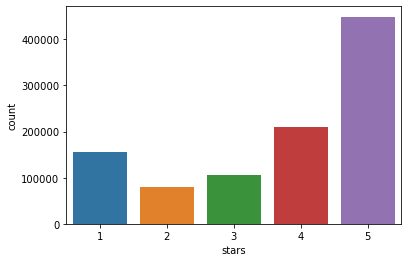

In [13]:
sns.countplot(simplified_reviews_pd['stars'])

In [14]:
counter_star = Counter(simplified_reviews_pd['stars'])

In [15]:
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 78882)

In [16]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 77808, 5: 370209, 4: 131481, 3: 26091, 2: 0}

In [17]:
remove_amounts[1] -= 1
remove_amounts

{1: 77807, 5: 370209, 4: 131481, 3: 26091, 2: 0}

In [18]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


605588

In [19]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

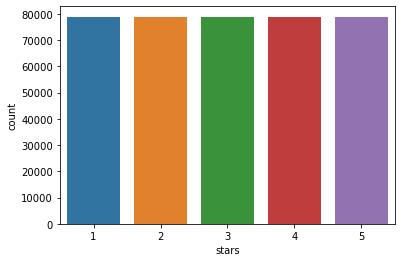

In [20]:
sns.countplot(balanced_simplified_reviews['stars'])

In [21]:
balanced_simplified_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394411 entries, 31 to 999998
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    394411 non-null  object
 1   stars   394411 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 19.0+ MB


In [22]:
balanced_simplified_reviews.to_pickle(path/'balanced_simplified_reviews.pkl')

In [23]:
!ls {path}

balanced_simplified_reviews.pkl      yelp_dataset.tar
Dataset_User_Agreement.pdf	     yelp_reviews_simple_1000000.json
yelp_academic_dataset_business.json  yelp_reviews_simple_2000000.json
yelp_academic_dataset_checkin.json   yelp_reviews_simple_200000.json
yelp_academic_dataset_review.json    yelp_reviews_simple_400000.json
yelp_academic_dataset_tip.json	     yelp_reviews_simple.json
yelp_academic_dataset_user.json
